In [1]:
import itertools

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import lab.metrics

In [2]:
def load_results(classifiers: list, factors: list):
    combinations = [(c, f) for c in classifiers for f in factors]
    return pd.concat([
        pd.read_csv(f"../results/predictions-{classifier}-{factor}-all.csv")
        for (classifier, factor) in combinations
    ], keys=combinations, names=["classifier", "factor", "sample"]).set_index("run", append=True).sort_index()


data = load_results(["varcnn", "kfp", "dfnet", "p1fp"], ("bgquic", "quic", "control"))
data

y_true        -1             0             1  \
classifier factor sample run                                                 
dfnet      bgquic 0      0      -1.0  1.000000  8.641420e-22  6.068292e-16   
                  1      0      -1.0  0.999852  1.054414e-08  6.983053e-11   
                  2      0      -1.0  0.999998  1.839594e-10  5.348780e-18   
                  3      0      85.0  0.000013  3.472684e-10  2.264830e-08   
                  4      0      -1.0  0.999914  1.951734e-08  2.797050e-10   
...                              ...       ...           ...           ...   
varcnn     quic   58565  9      -1.0  0.986896  3.528975e-23  9.546258e-20   
                  58566  9      -1.0  0.991453  3.429138e-19  1.414835e-08   
                  58567  9      40.0  0.493850  2.590780e-08  2.089568e-11   
                  58568  9      56.0  0.996009  4.900925e-14  7.256077e-19   
                  58569  9      48.0  0.002745  1.346443e-16  5.989587e-11   

                                         2             3             4  \
classifier factor sample run                                             
dfnet      bgquic 0      0    7.026364e-14  1.571981e-12  1.309063e-19   
                  1      0    4.264051e-06  5.993084e-08  1.767725e-11   
                  2      0    6.076204e-15  5.783835e-16  5.914418e-11   
                  3      0    5.353236e-18  2.001440e-12  4.407843e-12   
                  4      0    4.951522e-06  1.036843e-06  1.275554e-09   
...                                    ...           ...           ...   
varcnn     quic   58565  9    1.952789e-08  7.716641e-23  1.333886e-22   
                  58566  9    1.661993e-12  1.344338e-12  7.003602e-14   
                  58567  9    2.318362e-17  1.161703e-07  2.548839e-08   
                  58568  9    6.767293e-07  4.461758e-17  1.126489e-13   
                  58569  9    4.276876e-18  1.079825e-12  4.399800e-13   

                                         5             6             7  ...  \
classifier factor sample run                                            ...   
dfnet      bgquic 0      0    6.689348e-15  2.438565e-17  7.302184e-17  ...   
                  1      0    4.591279e-07  8.275363e-06  1.872238e-07  ...   
                  2      0    2.905587e-10  2.634524e-10  2.013264e-13  ...   
                  3      0    2.492408e-05  5.996313e-14  1.269785e-13  ...   
                  4      0    9.797326e-07  3.032402e-07  1.344438e-08  ...   
...                                    ...           ...           ...  ...   
varcnn     quic   58565  9    2.924288e-10  8.358027e-20  1.519002e-07  ...   
                  58566  9    5.866649e-06  3.004987e-10  6.657966e-08  ...   
                  58567  9    3.147360e-16  5.757980e-12  6.605399e-19  ...   
                  58568  9    5.993189e-08  4.598536e-13  3.690154e-13  ...   
                  58569  9    8.850282e-10  6.560783e-14  6.846338e-15  ...   

                                        90            91            92  \
classifier factor sample run                                             
dfnet      bgquic 0      0    6.328703e-25  1.888498e-12  5.348399e-20   
                  1      0    7.085785e-11  2.003855e-08  1.656498e-08   
                  2      0    4.268217e-15  3.749670e-12  1.255571e-11   
                  3      0    5.014401e-17  7.332505e-13  1.113717e-08   
                  4      0    3.052047e-11  1.892565e-07  6.770671e-10   
...                                    ...           ...           ...   
varcnn     quic   58565  9    1.560439e-17  4.705288e-20  3.914173e-07   
                  58566  9    6.076485e-14  7.275848e-17  3.125576e-09   
                  58567  9    3.134577e-14  3.182961e-11  6.201848e-16   
                  58568  9    2.265150e-11  4.780270e-10  1.241584e-11   
                  58569  9    3.198462e-16  1.066229e-18  1.805282e-13   

                                        93            94     

In [3]:
def score(frame, ratio):
    classes = np.arange(-1, 100)
    class_cols = [str(class_) for class_ in classes]
    probabilities = frame.loc[:, class_cols].values
    
    y_true = frame["y_true"]
    y_pred = classes[np.argmax(probabilities, axis=1)]
    
    return pd.Series({
        "precision": lab.metrics.rprecision_score(y_true, y_pred, ratio=ratio),
        "recall": lab.metrics.recall_score(y_true, y_pred)
    })


plot_data = (data
             .groupby(["classifier", "factor", "run"])
             .apply(score, ratio=20)
             .rename_axis("metric", axis=1)
             .stack()
             .rename("score")
             .transform(lambda x: x*100)
             .unstack("factor")
             .reorder_levels([0, 2, 1])
             .loc[:, ["control", "bgquic", "quic"]]
             .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
             .rename({"precision": "$\pi_{20}$ (%)", "recall": "Recall (%)"}, axis=0)
             .rename({"bgquic": "Unmon", "quic": "Both", "control": "Control"}, axis=1)
             .rename({1: "None"}, axis=1)
             .sort_index()
             .stack()
             .rename("value")
             .unstack(level="factor"))

plot_data

factor                           Control      Unmon       Both
classifier metric         run                                 
$k$-FP     $\pi_{20}$ (%) 0    93.919220  89.640157  86.715763
                          1    95.866432  87.225950  88.776364
                          2    92.832569  89.581910  85.035966
                          3    96.645205  92.014841  78.819039
                          4    92.832569  91.020395  90.565612
...                                  ...        ...        ...
Var-CNN    Recall (%)     5    96.100000  96.300000  47.500000
                          6    97.300000  96.400000  52.200000
                          7    97.300000  96.100000  50.200000
                          8    96.300000  91.400000  48.100000
                          9    98.300000  86.500000  47.000000

[80 rows x 3 columns]

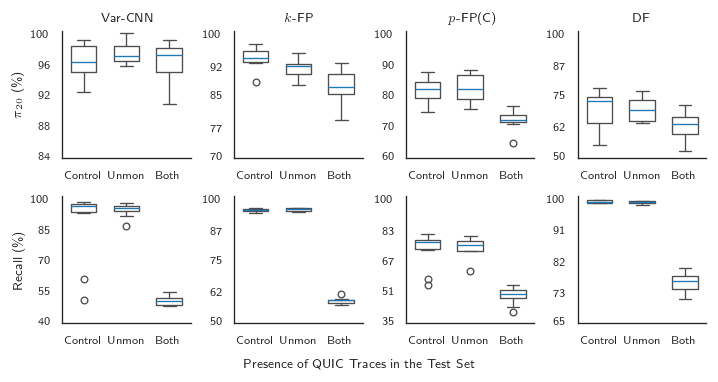

In [4]:
def plot_single(axes, classifier, metric, frame, label: bool = False, title: bool = False):
    axes.boxplot(frame.xs([classifier, metric]).values, widths=.6, labels=frame.columns)
    if label:
        axes.set_ylabel(metric.replace("%", "\%"))
    if title:
        axes.set_title(classifier)
        
        
def set_ylim(axes, bottom=None, top=100, num=5):
    if bottom is None:
        bottom = axes.get_ylim()[0]
        
    lim_range = (top - bottom)
    margin = lim_range * 0.02
    
    axes.set_ylim(bottom - margin, top + margin)
    
    y_ticks = np.linspace(start=bottom, stop=top, num=num, endpoint=True, dtype=int)
    axes.set_yticks(y_ticks)
    
        
def plot(plot_data):
    figure, axes = plt.subplots(2, 4, figsize=(6, 3), dpi=120) 

    results = {}
    for i, classifier in enumerate(plot_data.index.unique(level="classifier")[[3, 0, 1, 2]]):
        plot_single(axes[0][i], classifier, "$\pi_{20}$ (%)", plot_data, label=(i==0), title=True)
        plot_single(axes[1][i], classifier, "Recall (%)", plot_data, label=(i==0))

        for position in [0, 1]:
            axes[position][i].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.0f'))

        results[classifier] = (figure, axes[0][i], axes[1][i])

    figure.tight_layout(pad=1)
    figure.text(0.5, -0.025, 'Presence of QUIC Traces in the Test Set', ha='center')

    set_ylim(results["Var-CNN"][1], bottom=84)
    set_ylim(results["$k$-FP"][1], bottom=70)
    set_ylim(results["$p$-FP(C)"][1], bottom=60)
    set_ylim(results["DF"][1], bottom=50)

    set_ylim(results["Var-CNN"][2], bottom=40)
    set_ylim(results["$k$-FP"][2], bottom=50)
    set_ylim(results["$p$-FP(C)"][2], bottom=35)
    set_ylim(results["DF"][2], bottom=65)

    return figure

with plt.style.context([
    "mpl-style/pets.mplstyle",  "mpl-style/white.mplstyle", "mpl-style/box-plots.mplstyle", {"text.usetex": True}
]):
    figure = plot(plot_data)
    figure.savefig("../results/plots/score-vs-quic-presence.pgf", dpi=150, bbox_inches="tight")

In [5]:
(plot_data.groupby(["classifier", "metric"]).median()
 .assign(**{
     "(Control - Umon)": lambda df: df["Control"] - df["Unmon"],
     "(Control - _Both)": lambda df: df["Control"] - df["Both"],
 })
 .iloc[:, [3, 4]]
 .unstack("classifier")
 .stack("factor")
 .applymap("{0:.2g}".format)
 .iloc[:, [3, 0, 1, 2]])

classifier                       Var-CNN $k$-FP $p$-FP(C)   DF
metric         factor                                         
$\pi_{20}$ (%) (Control - Umon)    -0.71    1.8     0.039  3.5
               (Control - _Both)   -0.87      7        10  9.3
Recall (%)     (Control - Umon)     0.85   -0.2       1.8  0.1
               (Control - _Both)      47     37        27   23

In [6]:
def to_latex_table(data, float_fmt=".1f"):
    medians = data.groupby(level=[0, 1]).median()
    iq_range = data.groupby(level=[0, 1]).quantile([0.25, 0.75])
    iq_range.index.names = iq_range.index.names[:2] + ["IQR"]
    
    columns = data.columns.values
    metrics = data.index.unique(level=0).values
    factors = data.index.unique(level=1).values
    
    result_lines = []
    result_lines.append(r"\begin{tabular}{l%s}" % ("r" * len(columns)))
    result_lines.append(r"\toprule")
    result_lines.append(r" & %s \\" % " & ".join(columns))
    result_lines.append(r"\midrule")
    
    for metric in metrics:
        result_lines.append(r"metric = %s \\" % metric.replace("%", r"\%"))
        
        for factor in factors:
            fmt_string = f"{{median:{float_fmt}}} ({{lq:{float_fmt}}}--{{uq:{float_fmt}}})"
            values = [fmt_string.format(median=median, lq=lq, uq=uq) for (median, lq, uq) in 
                      zip(medians.xs([metric, factor]).values,
                          iq_range.xs([metric, factor, 0.25]),
                          iq_range.xs([metric, factor, 0.75]))]
            values = " & ".join(values)
            result_lines.append(r"\quad %s & %s \\" % (factor, values))
    result_lines.append(r"\bottomrule")
    result_lines.append(r"\end{tabular}")
    
    return "\n".join(result_lines)

print(to_latex_table(plot_data.stack().unstack("classifier").reorder_levels([0, 2, 1]).sort_index()))

\begin{tabular}{lrrrr}
\toprule
 & $k$-FP & $p$-FP(C) & DF & Var-CNN \\
\midrule
metric = $\pi_{20}$ (\%) \\
\quad Both & 86.9 (85.1--90.1) & 71.6 (71.1--73.5) & 62.9 (58.8--65.9) & 97.2 (95.0--98.1) \\
\quad Control & 93.9 (93.0--95.6) & 81.8 (79.0--84.2) & 72.2 (63.3--74.0) & 96.3 (95.0--98.4) \\
\quad Unmon & 92.1 (90.0--92.4) & 81.8 (78.6--86.4) & 68.7 (64.3--72.8) & 97.0 (96.4--98.3) \\
metric = Recall (\%) \\
\quad Both & 58.2 (57.2--58.6) & 49.4 (46.8--51.0) & 76.3 (74.2--77.9) & 49.6 (47.8--51.0) \\
\quad Control & 95.3 (95.0--95.7) & 76.8 (72.8--77.6) & 99.0 (98.7--99.4) & 96.2 (93.1--97.3) \\
\quad Unmon & 95.5 (94.9--95.8) & 75.0 (72.2--77.4) & 98.8 (98.6--99.2) & 95.3 (93.6--96.4) \\
\bottomrule
\end{tabular}
